In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import fbprophet
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from datetime import datetime
from xgboost import XGBRegressor 
from xgboost import plot_importance, plot_tree
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,StratifiedKFold

import lightgbm as lgb
%matplotlib inline

We parse the train.csv file using a custom datetime parser which matches with the format provided in the file

In [3]:
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M')

all_data = pd.read_csv("train.csv",index_col=['date'], parse_dates=['date'], date_parser=dateparse)

del all_data['id']
all_data.head()

speed
date                          
2017-01-01 00:00:00  43.002930
2017-01-01 01:00:00  46.118696
2017-01-01 02:00:00  44.294158
2017-01-01 03:00:00  41.067468
2017-01-01 04:00:00  46.448653

We do some plots here of the data to get an understanding of what the speeds look like. Below is a speed distribution

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



[Text(0.5, 0, 'speed'), Text(0.5, 1.0, 'Speed Distribution')]

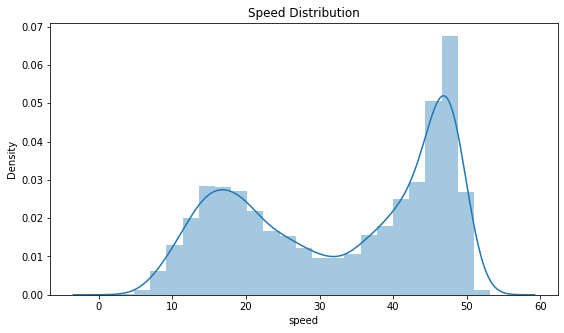

In [7]:
fig = plt.figure()
axis = fig.add_subplot(1, 2, 1)
fig.set_size_inches(20,5)

sns.distplot(all_data['speed'],ax=axis)
axis.set(xlabel='speed',title='Speed Distribution')

We also plot the individual speed points across time

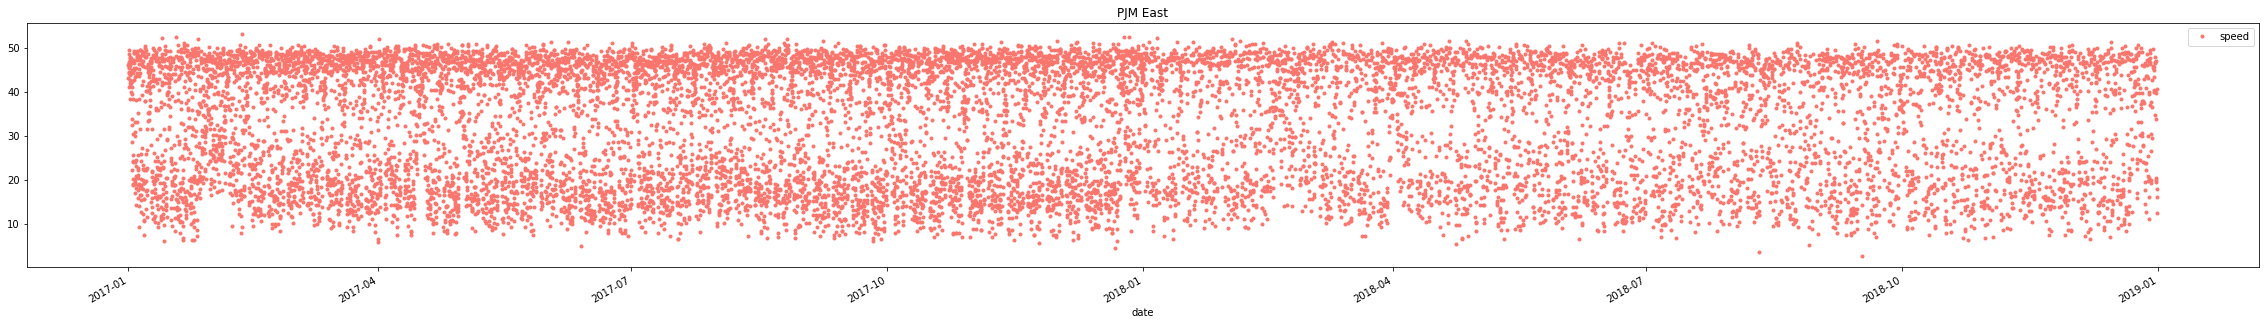

In [8]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = all_data.plot(style='.', figsize=(40,5), color=color_pal[0], title='PJM East')

Split data into training and test sets
* <=31-Oct-2018 = Train
* > 31-Oct-2018 = Test

In [9]:
split_date = '31-Oct-2018'
train = all_data.loc[all_data.index <= split_date].copy()
test = all_data.loc[all_data.index > split_date].copy()
# print(train)
# print(test)

orange is Training data
blue is Test data

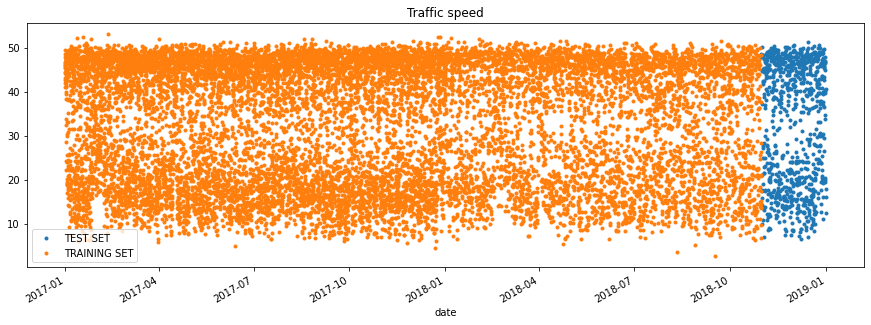

In [10]:
_ = test \
    .rename(columns={'speed': 'TEST SET'}) \
    .join(train.rename(columns={'speed': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Traffic speed', style='.')

We write a function to split the datetime field into its individual components like day, month, hour, day of the week, year, etc

Additionally we incorporate holidays by manually getting a list of public holidays in Hong Kong in 2017 and 2018

In [11]:
hk_holidays = ['2017-01-02', '2017-01-28','2017-01-30','2017-01-31','2017-01-30','2017-04-01','2017-04-14','2017-04-15','2017-04-17', 
                        '2017-05-01','2017-05-03','2017-05-30','2017-07-01','2017-10-02','2017-10-05','2017-10-28','2017-12-25','2017-12-26',
                        '2018-01-01', '2018-02-16','2018-02-17','2018-02-19','2018-03-30','2018-03-31','2018-04-02','2018-04-05',
                        '2018-05-01','2018-05-22','2018-06-18','2018-07-02','2018-09-25','2018-10-01','2018-10-17','2018-12-25','2018-12-26'
                        ]
dates_list = [datetime.strptime(date, '%Y-%m-%d').date() for date in hk_holidays]
print(dates_list)


def create_features(df, label=None, forsubmission=True):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['is_holiday'] = df['date'].dt.date.isin(dates_list)
    df["is_holiday"] = df["is_holiday"].astype(int)
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    # df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    if not forsubmission:
      df['lag_speed_1'] = df['speed'].shift(1)
      df['lag_speed_2'] = df['speed'].shift(2)
      df = df.dropna()
      X = df[['is_holiday', 'hour','dayofweek','month','year',
             'dayofyear','dayofmonth','weekofyear','lag_speed_1','lag_speed_2']]
    else:
      X = df[['is_holiday','hour','dayofweek','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    return X

[datetime.date(2017, 1, 2), datetime.date(2017, 1, 28), datetime.date(2017, 1, 30), datetime.date(2017, 1, 31), datetime.date(2017, 1, 30), datetime.date(2017, 4, 1), datetime.date(2017, 4, 14), datetime.date(2017, 4, 15), datetime.date(2017, 4, 17), datetime.date(2017, 5, 1), datetime.date(2017, 5, 3), datetime.date(2017, 5, 30), datetime.date(2017, 7, 1), datetime.date(2017, 10, 2), datetime.date(2017, 10, 5), datetime.date(2017, 10, 28), datetime.date(2017, 12, 25), datetime.date(2017, 12, 26), datetime.date(2018, 1, 1), datetime.date(2018, 2, 16), datetime.date(2018, 2, 17), datetime.date(2018, 2, 19), datetime.date(2018, 3, 30), datetime.date(2018, 3, 31), datetime.date(2018, 4, 2), datetime.date(2018, 4, 5), datetime.date(2018, 5, 1), datetime.date(2018, 5, 22), datetime.date(2018, 6, 18), datetime.date(2018, 7, 2), datetime.date(2018, 9, 25), datetime.date(2018, 10, 1), datetime.date(2018, 10, 17), datetime.date(2018, 12, 25), datetime.date(2018, 12, 26)]


Prepare Data for modelling

In [12]:
X_train, y_train = create_features(train, label='speed')
X_test, y_test = create_features(test, label='speed')
# print(train)
print(X_train)
print(y_train)
# test=test.dropna()
# print(test)
print(X_test)
print(y_test)

                     is_holiday  hour  ...  dayofmonth  weekofyear
date                                   ...                        
2017-01-01 00:00:00           0     0  ...           1          52
2017-01-01 01:00:00           0     1  ...           1          52
2017-01-01 02:00:00           0     2  ...           1          52
2017-01-01 03:00:00           0     3  ...           1          52
2017-01-01 04:00:00           0     4  ...           1          52
...                         ...   ...  ...         ...         ...
2018-10-30 17:00:00           0    17  ...          30          44
2018-10-30 18:00:00           0    18  ...          30          44
2018-10-30 19:00:00           0    19  ...          30          44
2018-10-30 20:00:00           0    20  ...          30          44
2018-10-31 00:00:00           0     0  ...          31          44

[13164 rows x 8 columns]
date
2017-01-01 00:00:00    43.002930
2017-01-01 01:00:00    46.118696
2017-01-01 02:00:00    44.294158

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



Baseline XGG, parameters trained using Grid Search CV done in the section below this one

In [13]:

reg = XGBRegressor(n_estimators=1044,max_depth=9,gamma=0.2,min_child_weight=13,
                   objective='reg:squarederror', tree_method='auto')
 
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
       verbose=False) # Change verbose to True if you want to see it train
test['speed_predicted'] = reg.predict(X_test)
all = pd.concat([test, train], sort=False)
mean_squared_error(y_true=test['speed'],
                   y_pred=test['speed_predicted'])
# {'eta': 0.5,
#  'gamma': 0.3,
#  'max_depth': 3,
#  'min_child_weight': 13,
#  'n_estimators': 200,
#  'tree_method': 'hist'}

# {'eta': 0.5,
#  'gamma': 0.3,
#  'max_depth': 3,
#  'min_child_weight': 16,
#  'n_estimators': 1044,
#  'tree_method': 'auto'}

# {'eta': 0.3,
#  'gamma': 0.3,
#  'max_depth': 6,
#  'min_child_weight': 1,
#  'n_estimators': 500,
#  'tree_method': 'approx'}

10.24159346734044

In [20]:
xgb_n_estimators = [int(x) for x in np.linspace(50, 500, 4)]

# Maximum number of levels in tree
xgb_max_depth = [int(x) for x in np.linspace(5, 20, 5)]

# Minimum number of instaces needed in each node
xgb_min_child_weight = [int(x) for x in np.linspace(1, 20, 5)]

# Tree construction algorithm used in XGBoost
xgb_tree_method = ['auto', 'exact', 'approx', 'hist']

# Learning rate
xgb_eta = [x for x in np.linspace(0.3, 0.9, 1)]

# Minimum loss reduction required to make further partition
xgb_gamma = [x for x in np.linspace(0, 0.9, 4)]

# # Learning objective used
# xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            # 'objective': xgb_objective
            }
xgb_grid

{'eta': [0.3],
 'gamma': [0.0, 0.3, 0.6, 0.9],
 'max_depth': [5, 8, 12, 16, 20],
 'min_child_weight': [1, 5, 10, 15, 20],
 'n_estimators': [50, 200, 350, 500],
 'tree_method': ['auto', 'exact', 'approx', 'hist']}

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:   35.7s
[Parallel(n_jobs=15)]: Done  60 out of  60 | elapsed:  3.7min finished


[14:10:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


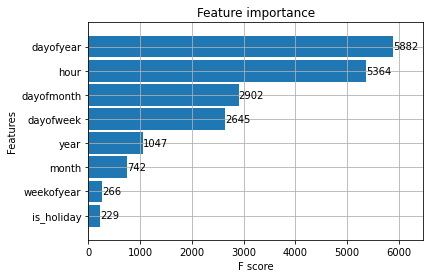

In [21]:

xgb_base = XGBRegressor()

# Create the random search Random Forest
xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid, 
                                n_iter = 20, cv = 3, verbose = 2, 
                                random_state = 420, n_jobs = 15)


# Fit the random search model
xgb_random.fit(X_train, y_train)

# Get the optimal parameters
xgb_random.best_params_

_ = plot_importance(reg, height=0.9)

In [22]:
xgb_random.best_params_

{'eta': 0.3,
 'gamma': 0.9,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 50,
 'tree_method': 'auto'}

Further parameter tuning for XGBoost. This time I list my scores as acheived for different modesl on training data as well as test data submissions on the Kaggle competition. 

I choose the model which gives me best test data results and where training and test data dont differ by a big amount. 

[14:23:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


10.513585181529901

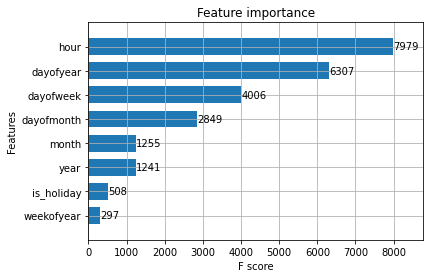

In [24]:
# model = XGBRegressor(n_estimators=1044,max_depth=9,gamma=0.2,min_child_weight=13,objective='reg:squarederror', tree_method='auto') #s - 10.81 
# model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.09, subsample=0.8, base_score=0.7)  # t - 10.35 submission - 10.08
# model = XGBRegressor(n_estimators=500, max_depth=7, learning_rate=0.09, subsample=0.8, base_score=0.7)  # t - 10.53 submission - 10.09
# model = XGBRegressor(n_estimators=500, max_depth=7, learning_rate=0.08, subsample=0.8, base_score=0.7)  # t - 10.46 s - 9.965
# model = XGBRegressor(n_estimators=500, max_depth=8, learning_rate=0.08, subsample=0.8, base_score=0.7)  # t - 10.4679 s - 10.12
model = XGBRegressor(n_estimators=300, max_depth=8, learning_rate=0.07, subsample=0.9, base_score=0.7)  # t - 10.51 s - 9.83 -> best model -> submission 1
# model = XGBRegressor(n_estimators=300, max_depth=8, learning_rate=0.07, subsample=0.8, base_score=0.7)  # t - 10.187 s - 9.98 -> second best model -> submission 2
# model = XGBRegressor(n_estimators=300, max_depth=10, learning_rate=0.08, subsample=0.8, base_score=0.7)  # t - 11.124 s - 10.25
# model = XGBRegressor(n_estimators=260, max_depth=9, learning_rate=0.08, subsample=0.8, base_score=0.7)  # t - 11.16 s - 9.80 -> Although this model gave me the best results the difference between training test set validation and submission made me a bit skeptical about submitting this result.
# model = XGBRegressor(n_estimators=500, max_depth=8, learning_rate=0.06, subsample=0.9, base_score=0.7)  # t - 10.28 s - 9.96
# model = XGBRegressor(n_estimators=600, max_depth=6, learning_rate=0.09)  # train - 10.39 submission - 10.29



model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)


from xgboost import plot_importance
_ = plot_importance(model, height=0.7)

test['speed_predicted'] = model.predict(X_test)
all = pd.concat([test, train], sort=False)
mean_squared_error(y_true=test['speed'],
                   y_pred=test['speed_predicted'])

We retrain the models but this time we pick the best model. Also we use the entire data instead of using only X_train part from train test split. 

In [25]:
model_best = XGBRegressor(n_estimators=300, max_depth=8, learning_rate=0.07, subsample=0.8, base_score=0.7)
X_train_all, y_train_all = create_features(all_data, label='speed')
model_best.fit(X_train_all, y_train_all, verbose=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[14:23:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.7, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [ ]:
submission_data = pd.read_csv("test.csv",index_col=['date'], parse_dates=['date'], date_parser=dateparse)

del submission_data['id']
# print(submission_data)
X_submit = create_features(submission_data,forsubmission=True)
print(X_submit)

finalprediction = model_best.predict(X_submit)
print(finalprediction)
new_test = pd.read_csv("test.csv",index_col=['id'], parse_dates=['date'], date_parser=dateparse)
new_test['speed'] = finalprediction.tolist()
print(new_test.head())
finalcsv = new_test.drop(columns='date')
print(finalcsv.head())
len(finalcsv)
finalcsv.to_csv("finalcsv_1.csv")

                     is_holiday  hour  ...  dayofmonth  weekofyear
date                                   ...                        
2018-01-01 02:00:00           1     2  ...           1           1
2018-01-01 05:00:00           1     5  ...           1           1
2018-01-01 07:00:00           1     7  ...           1           1
2018-01-01 08:00:00           1     8  ...           1           1
2018-01-01 10:00:00           1    10  ...           1           1
...                         ...   ...  ...         ...         ...
2018-12-31 17:00:00           0    17  ...          31           1
2018-12-31 19:00:00           0    19  ...          31           1
2018-12-31 21:00:00           0    21  ...          31           1
2018-12-31 22:00:00           0    22  ...          31           1
2018-12-31 23:00:00           0    23  ...          31           1

[3504 rows x 8 columns]
[48.350372 47.549072 40.754192 ... 46.410114 42.311356 43.751854]
                  date      speed
id  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



Plot predicted speeds from X_train after train test split. Orange is the prediction

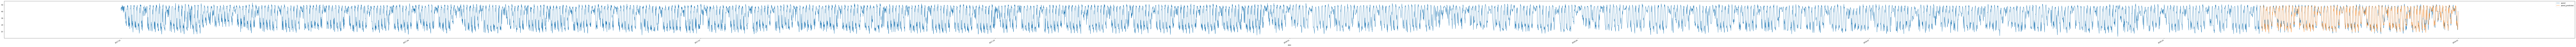

In [27]:
_ = all[['speed','speed_predicted']].plot(figsize=(300, 5))


# light GBM

Now we try the Light GBM model. We already tried XGBoost earlier. Light GBM also gives similar results 

In [28]:
param = {'max_depth': 9, 'num_leaves': 150, 'num_trees':100, 'objective':'regression', 'iterations':1000, 'learning_rate':0.1, 'metric':'mse'}
data_train_cur = lgb.Dataset(X_train, y_train)
model = lgb.train(param, data_train_cur)
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_trees` in params. Will use it instead of argument



In [29]:
mean_squared_error(y_true=test['speed'],
                   y_pred=y_pred)

10.467636016286187

In [30]:
mdl = lgb.LGBMRegressor(boosting_type= 'gbdt', 
          objective = 'regression', 
          n_jobs = 5, 
          silent = True,
          max_depth = 10,
          max_bin =500, 
          subsample_for_bin = 200,
          subsample = 1, 
          min_split_gain = 0.5, 
          min_child_weight = 1, 
          min_child_samples = 5)

mdl.get_params().keys()

gridParams = {
    'learning_rate': [0.1,0.2],
    'n_estimators': [50, 100,150],
    'num_leaves': [4,7, 10], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt'], 
    'objective' : ['regression'],
    'max_bin':[50, 100, 150], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    # 'colsample_bytree' : [0.64, 0.65, 0.66],
    # 'subsample' : [0.7,0.75],
    # 'reg_alpha' : [0.5, 1,1.1],
    # 'reg_lambda' : [0.5, 1, 1.2],
    }
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)
grid.fit(X=X_train, y=y_train)

print(grid.best_params_)
print(grid.best_score_)


Fitting 4 folds for each of 54 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   36.5s finished


{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_bin': 150, 'n_estimators': 100, 'num_leaves': 10, 'objective': 'regression', 'random_state': 500}
0.9130518175875584


In [32]:
# param = {'boosting_type': 'gbdt', 'learning_rate': 0.2, 'max_bin': 150, 'n_estimators': 100, 'num_leaves': 10, 'objective': 'regression', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 0.5}# t - 11.264 s - 9.96
param = {'boosting_type': 'gbdt', 'learning_rate': 0.2, 'max_bin': 100, 'n_estimators': 150, 'num_leaves': 15, 'objective': 'regression', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1}# t - 11.182 s - 11.929
data_train_cur = lgb.Dataset(X_train, y_train)
model = lgb.train(param, data_train_cur)
y_pred = model.predict(X_test)


mean_squared_error(y_true=test['speed'],
                   y_pred=y_pred)


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



11.182635595914672

In [33]:
param = {'boosting_type': 'gbdt', 'learning_rate': 0.2, 'max_bin': 100, 'n_estimators': 150, 'num_leaves': 15, 'objective': 'regression', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1}
X_train_all, y_train_all = create_features(all_data, label='speed')
data_train_cur = lgb.Dataset(X_train_all, y_train_all)
model = lgb.train(param, data_train_cur)

submission_data = pd.read_csv("test.csv",index_col=['date'], parse_dates=['date'], date_parser=dateparse)

del submission_data['id']
# print(submission_data)
X_submit = create_features(submission_data,forsubmission=True)
print(X_submit)

finalprediction = model.predict(X_submit)
print(finalprediction)
new_test = pd.read_csv("test.csv",index_col=['id'], parse_dates=['date'], date_parser=dateparse)
new_test['speed'] = finalprediction.tolist()
print(new_test.head())
finalcsv = new_test.drop(columns='date')
print(finalcsv.head())
len(finalcsv)
finalcsv.to_csv("finalcsv_1_lgb.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



                     is_holiday  hour  ...  dayofmonth  weekofyear
date                                   ...                        
2018-01-01 02:00:00           1     2  ...           1           1
2018-01-01 05:00:00           1     5  ...           1           1
2018-01-01 07:00:00           1     7  ...           1           1
2018-01-01 08:00:00           1     8  ...           1           1
2018-01-01 10:00:00           1    10  ...           1           1
...                         ...   ...  ...         ...         ...
2018-12-31 17:00:00           0    17  ...          31           1
2018-12-31 19:00:00           0    19  ...          31           1
2018-12-31 21:00:00           0    21  ...          31           1
2018-12-31 22:00:00           0    22  ...          31           1
2018-12-31 23:00:00           0    23  ...          31           1

[3504 rows x 8 columns]
[47.22373354 46.93569591 36.73589931 ... 46.45799717 42.82482015
 44.95040175]
                  date   

In [35]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M')

all_data = pd.read_csv("train.csv",index_col=['date'], parse_dates=['date'], date_parser=dateparse)

del all_data['id']
all_data.head()
moving_average(all_data, 24) # prediction for the last observed day (past 24 hours)

36.44110875041667

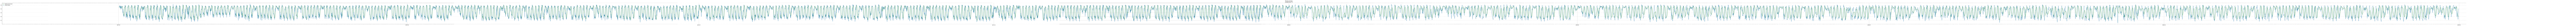

In [36]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(600,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(all_data[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
plotMovingAverage(all_data, 5) 



In [ ]:
all_data.head()

speed
date                          
2017-01-01 00:00:00  43.002930
2017-01-01 01:00:00  46.118696
2017-01-01 02:00:00  44.294158
2017-01-01 03:00:00  41.067468
2017-01-01 04:00:00  46.448653

## **LSTM**

Next we try LSTM with Tensorflow and Keras. However the results for LSTM were not that good so none of my submissions use LSTM

In [ ]:
import glob
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import numpy as np
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
# define input sequence
timeseries_data = []
for x in all_data.values.tolist():
    for y in x:
        timeseries_data.append(y)
print(timeseries_data)
# choose a number of time steps
n_steps = 168
# split into samples
X, y = prepare_data(timeseries_data, n_steps)

[43.00293016, 46.11869568, 44.29415804, 41.06746764, 46.44865313, 46.79776582, 44.4049252, 45.25589692, 45.68085866, 48.43567634, 49.4570539, 41.968518599999996, 42.72473472, 47.93645857, 45.97188063, 41.35986149, 43.86803313, 47.61554073, 38.35276019, 47.26892837, 46.44475569, 41.981908399999995, 39.81723982, 44.27782113, 47.62156284, 47.07016077, 46.89492264, 47.061394899999996, 47.01615626, 44.82629585, 42.37291267, 41.03940657, 28.42375086, 33.6611834, 39.49302198, 32.44394381, 22.15993177, 24.32208805, 25.68121704, 23.944490100000003, 18.73019161, 18.97422526, 20.09936358, 30.30038076, 38.23933239, 44.18686543, 42.60273783, 44.89217148, 48.66582335, 49.25749603, 46.44221828, 48.86047714, 47.15122779, 45.46067216, 43.32843989, 23.93352837, 16.92674997, 19.09222538, 33.11256658, 19.44291389, 29.79058532, 30.78994075, 20.213874899999997, 18.05015491, 23.04990915, 20.7917376, 14.15768031, 24.53891079, 37.97752767, 45.28052513, 43.53418423, 47.21748539, 48.15083185, 48.88211979, 48.579

In [ ]:
print(X),print(y)


[[43.00293016 46.11869568 44.29415804 ... 40.16778996 35.175395
  33.350155  ]
 [46.11869568 44.29415804 41.06746764 ... 35.175395   33.350155
  45.02945502]
 [44.29415804 41.06746764 46.44865313 ... 33.350155   45.02945502
  46.27002343]
 ...
 [47.40526442 16.22109966 17.32833904 ... 33.85112103 19.86526916
  17.82037545]
 [16.22109966 17.32833904 25.82929967 ... 19.86526916 17.82037545
  12.50185109]
 [17.32833904 25.82929967 23.49580494 ... 17.82037545 12.50185109
  15.97931873]]
[45.02945502 46.27002343 45.65299811 ... 12.50185109 15.97931873
 40.59418269]


(None, None)

In [ ]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))


In [ ]:
model = Sequential()
model.add(LSTM(200, activation='softmax', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation='softmax'))
model.add(Dense(1))
# model.add(Dense(800,input_shape=(n_steps,n_features)))
# model.add(LeakyReLU(alpha=0.1))

opt = keras.optimizers.Adam()

model.compile(optimizer=opt, loss='mse')
# fit model
model.fit(X, y, epochs=300, verbose=1)

Epoch 1/300
433/433 [==============================] - 368s 850ms/step - loss: 1233.1923
Epoch 2/300
433/433 [==============================] - 365s 843ms/step - loss: 1138.5009
Epoch 3/300
433/433 [==============================] - 366s 845ms/step - loss: 1068.0021
Epoch 4/300
433/433 [==============================] - 376s 868ms/step - loss: 1014.5181
Epoch 5/300
433/433 [==============================] - 340s 786ms/step - loss: 965.2581
Epoch 6/300
433/433 [==============================] - 341s 787ms/step - loss: 918.7452
Epoch 7/300
433/433 [==============================] - 358s 826ms/step - loss: 874.3959
Epoch 8/300
433/433 [==============================] - 369s 852ms/step - loss: 831.9748
Epoch 9/300
433/433 [==============================] - 375s 866ms/step - loss: 791.2474
Epoch 10/300
433/433 [==============================] - 364s 840ms/step - loss: 752.0944
Epoch 11/300
433/433 [==============================] - 360s 830ms/step - loss: 714.4337
Epoch 12/300
433/433 [====